# 원리

* 특성들이 통계적으로 상관관계가 없도록 데이터셋을 회전시키는 기술
* Covariance Matrix의 eingenvector들 중에서 eigenvalue가 큰 순(분산이 큰방향)으로 구함
* 차원을 축소하거나 노이즈를 제거하는 용도로 쓰일 수 있음

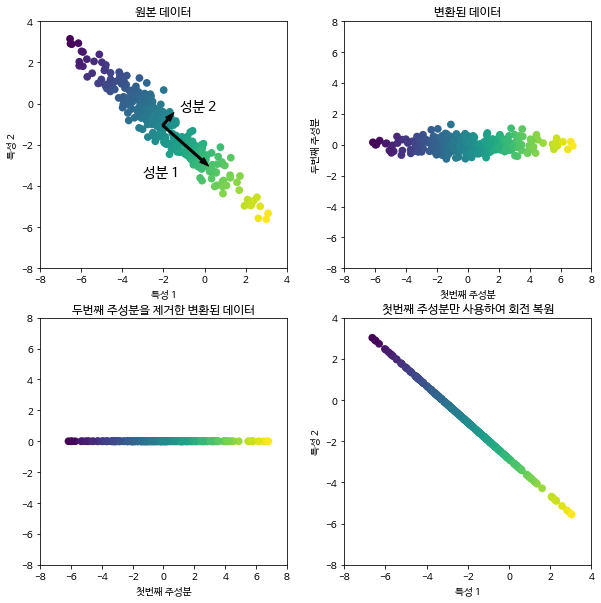

In [1]:
from ml1.preamble import*
mglearn.plots.plot_pca_illustration()

# 고차원 데이터 시각화

## 방법 1

* 특성이 많은 경우 scatter matrix 마저 힘듬
* 그런 경우 각 특성마다 클래스에 대해 히스토그램을 그릴 수 있음

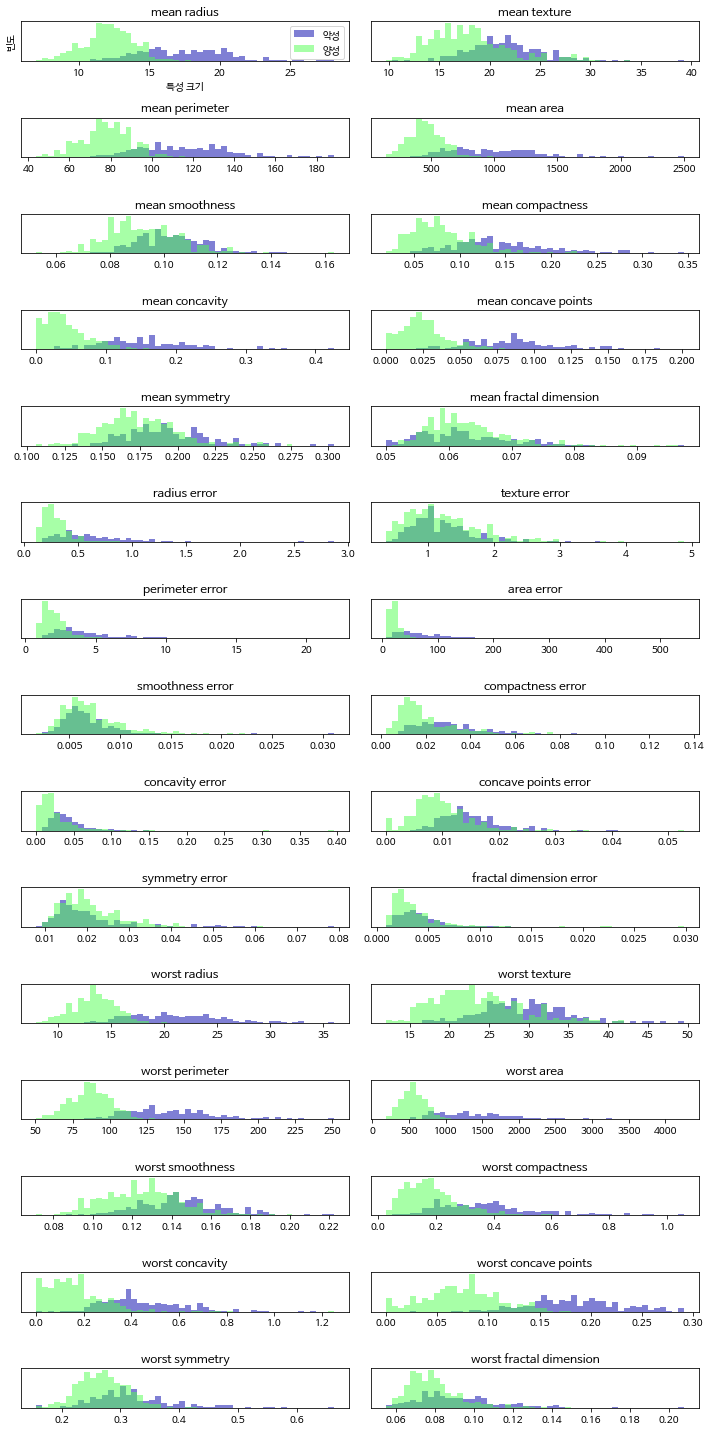

In [2]:
from sklearn.datasets import load_breast_cancer
cancer= load_breast_cancer()

fig, axes = plt.subplots(15, 2, figsize=(10,20))
malignant , benign = cancer.data[cancer.target==0], cancer.data[cancer.target==1]
ax= axes.ravel()
for i in range(30):
    _, bins = np.histogram(cancer.data[:,i], bins=50)
    ax[i].hist(malignant[:,i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:,i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel('특성 크기')
ax[0].set_ylabel('빈도')
ax[0].legend(['악성', '양성'], loc='best')
fig.tight_layout()

## 방법 2

* PCA로 차원 축소
* PCA 변환 전 스케일을 맞춰줘야 함

Text(0.5, 0, '두 번째 주성분')

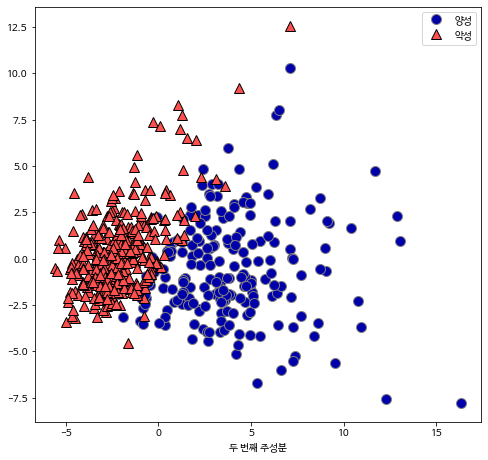

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(cancer.data)
pca = PCA(n_components=2)  # 2개의 성분만 추출
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:,0], X_pca[:,1], cancer.target)
plt.legend(['양성', '악성'], loc='best')
plt.gca().set_aspect('equal')
plt.xlabel('첫 번째 주성분')
plt.xlabel('두 번째 주성분')

* 주성분의 구성

PCA 주성분 :
 [[ 0.219  0.104  0.228  0.221  0.143  0.239  0.258  0.261  0.138  0.064
   0.206  0.017  0.211  0.203  0.015  0.17   0.154  0.183  0.042  0.103
   0.228  0.104  0.237  0.225  0.128  0.21   0.229  0.251  0.123  0.132]
 [-0.234 -0.06  -0.215 -0.231  0.186  0.152  0.06  -0.035  0.19   0.367
  -0.106  0.09  -0.089 -0.152  0.204  0.233  0.197  0.13   0.184  0.28
  -0.22  -0.045 -0.2   -0.219  0.172  0.144  0.098 -0.008  0.142  0.275]]


Text(0, 0.5, '주성분')

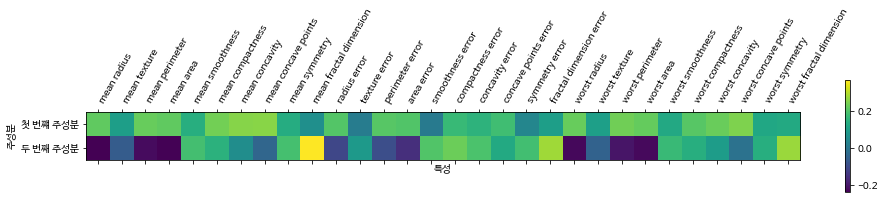

In [4]:
print('PCA 주성분 :\n', pca.components_)

plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1],['첫 번쨰 주성분', '두 번째 주성분'])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)), cancer.feature_names, rotation=60, ha='left')
plt.xlabel('특성')
plt.ylabel('주성분')

# Eigenface 특성 추출

* 사용할 데이터

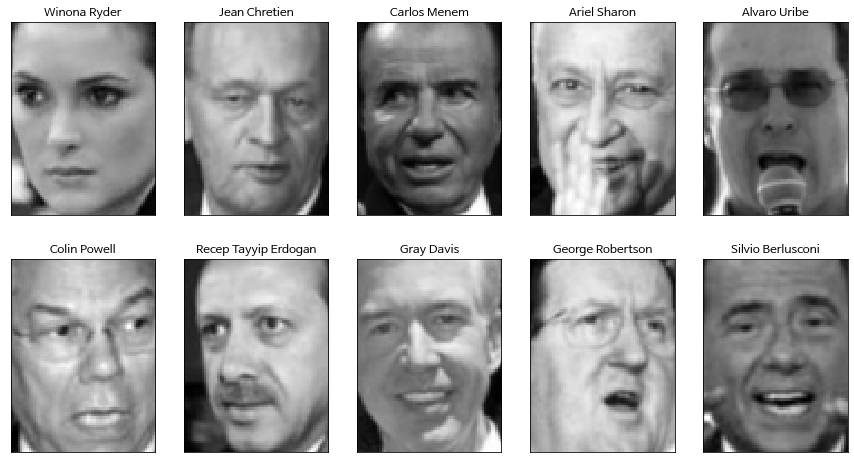

In [5]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

# 사람당 50개만 사용
mask = np.zeros(people.target.shape, dtype= np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask] / 255
y_people = people.target[mask]

fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks':[], 'yticks':[]})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap='gray')
    ax.set_title(people.target_names[target])

* KNN을 사용하는 경우

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify= y_people, random_state=0 )
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
print(f'1-최근접 이웃의 테스트 세트 점수: {knn.score(X_test, y_test):.2f}')

1-최근접 이웃의 테스트 세트 점수: 0.23


* PCA whitening으로 변환 후 KNN

In [7]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=1).fit(X_train_pca, y_train)
print(f'PCA-KNN 테스트 세트 점수: {knn.score(X_test_pca, y_test):.2f}')

PCA-KNN 테스트 세트 점수: 0.31


* components_ 로 주성분 확인

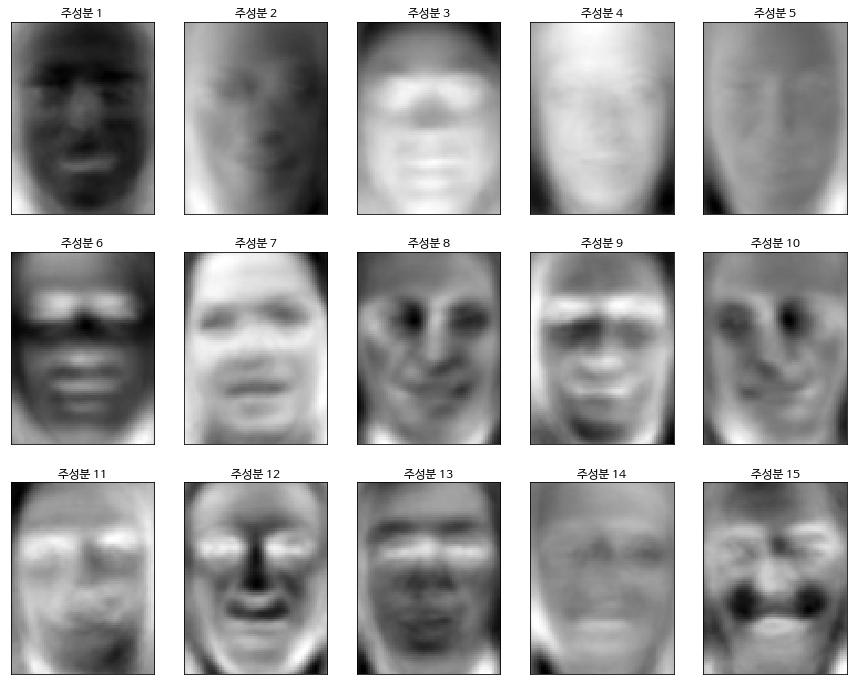

In [8]:
fig, axes = plt.subplots(3,5, figsize=(15,12), subplot_kw={'xticks':[], 'yticks':[]})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(people.images[0].shape), cmap='gray')
    ax.set_title(f'주성분 {i+1}')

* inverse_transform : 원래 특성 공간으로 되돌림

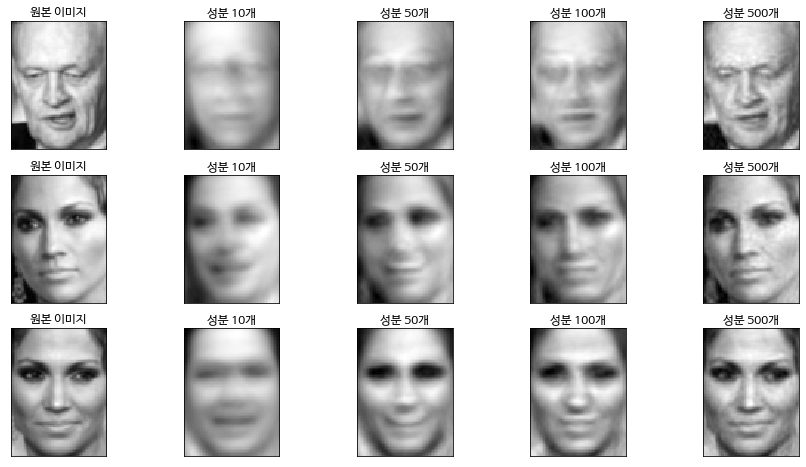

In [9]:
fig, axes = plt.subplots(3, 5, figsize=(15,8),subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes[:,0].ravel()):
    ax.imshow(X_test[i].reshape(people.images[0].shape), cmap='gray')
    ax.set_title('원본 이미지')
for i, n_component in enumerate([10, 50, 100, 500]):
    pca = PCA(n_components = n_component, whiten=True, random_state=0)
    pca.fit(X_train)
    X_test_pca = pca.transform(X_test)
    X_back = pca.inverse_transform(X_test_pca[:3])
    for ax, im in zip(axes[:,i+1].ravel(), X_back):
        ax.imshow(im.reshape(people.images[0].shape), cmap='gray')
        ax.set_title(f'성분 {n_component}개')

* 주성분 2개에 대한 산점도

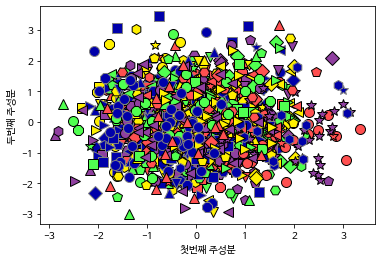

In [10]:
mglearn.discrete_scatter(X_train_pca[:,0],X_train_pca[:,1],y_train)
plt.xlabel('첫번째 주성분')
plt.ylabel('두번째 주성분')
plt.show()

=> 위에서 보듯이 주성분 10개를 사용하더라도 얼굴이 잘 구별되지 않으므로 2개도 당연히 이쁘게 안나옴